In [1]:
import cv2 as cv
import os
import numpy as np
import pdb
import ntpath
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import glob
import pickle
from copy import deepcopy
import timeit
from skimage.feature import hog
import pandas as pd
from random import randint
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
from multiprocessing.pool import ThreadPool
import hashlib


In [2]:
class Parameters:
    def __init__(self):
        # self.base_dir = '../data'
        self.dir_pos_examples = 'positiveExamples'
        self.dir_neg_examples = 'negativeExamples'
        #self.dir_test_examples = os.path.join(self.base_dir,'testare')
        self.dir_validation_examples = 'validare/validare'
        self.path_annotations = 'validare/task1_gt_validare.txt'
        self.dir_save_files = 'salveazaFisiere'
        # if not os.path.exists(self.dir_save_files):
        #     os.makedirs(self.dir_save_files)
        #     print('directory created: {} '.format(self.dir_save_files))
        # else:
        #     print('directory {} exists '.format(self.dir_save_files))

        # set the parameters
        self.image_size=(162,162)
        self.dim_window = 162  # dimensiunea ferestrei glisante
        self.dim_hog_cell = 6  # dimensiunea celulei
        self.dim_descriptor_cell = 162  # dimensiunea descriptorului unei celule
        self.bins = 9 # numarul de binuri folosit in histograma gradientului
        self.overlap = 0.2
        self.number_positive_examples = None  # numarul exemplelor pozitive
        self.number_negative_examples = None  # numarul exemplelor negative
        self.image_transformations=[] # numele transformarilor de imagine folosite
        self.threshold = 0
parameters = Parameters()
average_face_width = 0
average_face_height = 0
no_faces = 0

In [3]:
def process_image(row, image_dir, output_dir, target_size, width_sum = 0, height_sum = 0, face_count = 0, resize_step = 0.1):
    image_path = os.path.join(image_dir, row['image'])
    if not os.path.exists(image_path):
        return average_face_width, average_face_height, no_faces

    image = cv.imread(image_path)
    if image is None:
        return average_face_width, average_face_height, no_faces
    
    target_size = parameters.image_size

    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    face_width = xmax - xmin
    face_height = ymax - ymin    
    # face = image[ymin:ymax, xmin:xmax]

    # Extract the face region
    face_crop = image[ymin:ymax, xmin:xmax]
    
    # Compute the current dimensions of the face crop
    face_height, face_width = face_crop.shape[:2]
    
    # If the crop already matches the target size, return it
    if not(face_height == target_size[1] and face_width == target_size[0]):

        # Calculate padding needed to reach the target size
        pad_height = max(target_size[1] - face_height, 0)
        pad_width = max(target_size[0] - face_width, 0)
        
        # Expand the crop to include surrounding context
        top = max(0, ymin - pad_height // 2)
        bottom = min(image.shape[0], ymax + pad_height // 2)
        left = max(0, xmin - pad_width // 2)
        right = min(image.shape[1], xmax + pad_width // 2)

        expanded_crop = image[top:bottom, left:right]
        
        # If the expanded crop is still smaller than target size, pad with black pixels
        expanded_height, expanded_width = expanded_crop.shape[:2]
        if expanded_height < target_size[1] or expanded_width < target_size[0]:
            pad_top = max((target_size[1] - expanded_height) // 2,0)
            pad_bottom = max(target_size[1] - expanded_height - pad_top,0)
            pad_left = max((target_size[0] - expanded_width) // 2,0)
            pad_right = max(target_size[0] - expanded_width - pad_left,0)
            expanded_crop = cv.copyMakeBorder(
            expanded_crop,
            pad_top, pad_bottom, pad_left, pad_right,
            cv.BORDER_REFLECT  # Use mirrored padding
            )
        face = expanded_crop
    
    # if laplacian<500:
    #     return width_sum, height_sum, face_count
    # Incrementally resize the face to the target size
    current_size = (face_width, face_height)
    # while current_size != target_size:
    #     if current_size[0] > target_size[0] or current_size[1] > target_size[1]:
    #         # Shrink the face
    #         scale_factor = 1 - resize_step
    #     else:
    #         # Enlarge the face
    #         scale_factor = 1 + resize_step

    #     # Calculate new dimensions
    #     new_width = int(current_size[0] * scale_factor)
    #     new_height = int(current_size[1] * scale_factor)

    #     # Prevent overshooting the target size
    #     if scale_factor < 1 and (new_width < target_size[0] or new_height < target_size[1]):
    #         new_width, new_height = target_size
    #     elif scale_factor > 1 and (new_width > target_size[0] or new_height > target_size[1]):
    #         new_width, new_height = target_size

    #     # Resize the face
    #     face = cv.resize(face, (new_width, new_height), interpolation=cv.INTER_CUBIC)
    #     laplacian = cv.Laplacian(face, cv.CV_64F).var()
    #     current_size = (new_width, new_height)

    width_sum += face_width
    height_sum += face_height
    face_count += 1

    label_dir = os.path.join(output_dir, row['label'])
    os.makedirs(label_dir, exist_ok=True)
    face_filename = os.path.join(label_dir, f"{row['image'][:-4]}_{xmin}_{ymin}.jpg")
    #print(face_filename+": "+str(laplacian))
    if not os.path.exists(face_filename):# and laplacian>75:
        cv.imwrite(face_filename, face)
    return width_sum, height_sum, face_count

In [4]:
def extract_faces(image_dir, annotations_file, output_dir, target_size=parameters.image_size):

    annotations = pd.read_csv(annotations_file, delimiter=" ", header=None, names=["image", "xmin", "ymin", "xmax", "ymax","label"],index_col=False)  #Format: image, xmin, ymin, xmax, ymax, label
    # print(annotations.head())
    # Ensure output directory structure
    os.makedirs(output_dir+str(target_size[0]), exist_ok=True)

    # Initialize accumulators
    width_sum = 0
    height_sum = 0
    face_count = 0
    
    with ThreadPoolExecutor() as executor:
        futures = []
        for _, row in annotations.iterrows():
            futures.append(executor.submit(process_image, row, image_dir, output_dir + str(target_size[0]), target_size, width_sum, height_sum, face_count))

        # Collect results
        for future in futures:
            width_sum, height_sum, face_count = future.result()
    if face_count > 0:
        average_face_width = width_sum / face_count
        average_face_height = height_sum / face_count
        print(f"Average face width: {average_face_width}")
        print(f"Average face height: {average_face_height}")
    else:
        print("No valid faces processed.")
    return average_face_width, average_face_height, face_count


In [198]:
# Example usage
extract_faces(
    image_dir="antrenare/dad",
    annotations_file="antrenare/dad_annotations.txt",
    output_dir="positiveExamplesTestt",
)
# Example usage
extract_faces(
    image_dir="antrenare/deedee",
    annotations_file="antrenare/deedee_annotations.txt",
    output_dir="positiveExamplesTestt",
)
# Example usage
extract_faces(
    image_dir="antrenare/dexter",
    annotations_file="antrenare/dexter_annotations.txt",
    output_dir="positiveExamplesTestt",
)
# Example usage
extract_faces(
    image_dir="antrenare/mom",
    annotations_file="antrenare/mom_annotations.txt",
    output_dir="positiveExamplesTestt",
)

Average face width: 223.0
Average face height: 154.0
Average face width: 74.0
Average face height: 41.0
Average face width: 279.0
Average face height: 173.0
Average face width: 172.0
Average face height: 182.0


(172.0, 182.0, 1)

In [5]:
def augment_face(face):
    augmented_faces = [face]
    augmented_faces.append(cv.rotate(face, cv.ROTATE_90_CLOCKWISE))
    augmented_faces.append(cv.flip(face, 1))  # Horizontal flip
    return augmented_faces[2]

def get_positive_descriptors(path_to_images,flip_images=False):
    # in aceasta functie calculam descriptorii pozitivi
    # vom returna un numpy array de dimensiuni NXD
    # unde N - numar exemplelor pozitive
    # iar D - dimensiunea descriptorului
    # D = (params.dim_window/params.dim_hog_cell - 1) ^ 2 * params.dim_descriptor_cell (fetele sunt patrate)

    images_path = os.path.join(path_to_images, '*.jpg')
    files = glob.glob(images_path)
    num_images = len(files)
    positive_descriptors = []
    print('Calculam descriptorii pt %d imagini pozitive...' % num_images)
    for i in range(0,num_images,10):
        print('Procesam batch-ul cu 10 imagini nr. %d...' % (i//10+1))
        batch_files = files[i:i+10]
        batch_images = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in batch_files]
        for img in batch_images:
            if img is None:
                continue
            if img.shape != (parameters.dim_window, parameters.dim_window):
                # print("wrong size")
                img=cv.resize(img, (parameters.dim_window, parameters.dim_window), interpolation=cv.INTER_CUBIC)
            features = hog(img, pixels_per_cell=(parameters.dim_hog_cell,parameters.dim_hog_cell), 
                           cells_per_block=(2, 2), feature_vector=True, 
                           orientations=parameters.bins
                           )
            positive_descriptors.append(features)
            if flip_images:
                flipped_features = hog(np.fliplr(img), pixels_per_cell=(parameters.dim_hog_cell,parameters.dim_hog_cell), 
                                       cells_per_block=(2, 2), feature_vector=True,
                                       orientations=parameters.bins
                                       )
                positive_descriptors.append(flipped_features)
    try: 
        positive_descriptors = np.array(positive_descriptors)
    except:
        print('Error converting to numpy array')
    return positive_descriptors

In [6]:
dad_path = 'positiveExamplesTesttt'+str(parameters.dim_descriptor_cell)+'/dad'
deedee_path = 'positiveExamplesTesttt'+str(parameters.dim_descriptor_cell)+'/deedee'
dexter_path = 'positiveExamplesTesttt'+str(parameters.dim_descriptor_cell)+'/dexter'
mom_path = 'positiveExamplesTesttt'+str(parameters.dim_descriptor_cell)+'/mom'
unknown_path = 'positiveExamplesTesttt'+str(parameters.dim_descriptor_cell)+'/unknown'
dad_positive_descriptors = get_positive_descriptors(dad_path,flip_images=True)
deedee_positive_descriptors = get_positive_descriptors(deedee_path,flip_images=True)
dexter_positive_descriptors = get_positive_descriptors(dexter_path,flip_images=True)
mom_positive_descriptors = get_positive_descriptors(mom_path,flip_images=True)
unknown_positive_descriptors = get_positive_descriptors(unknown_path,flip_images=True)
all_positive_descriptor = np.concatenate((dad_positive_descriptors,deedee_positive_descriptors,dexter_positive_descriptors,mom_positive_descriptors,unknown_positive_descriptors),axis=0)

Calculam descriptorii pt 1286 imagini pozitive...
Procesam batch-ul cu 10 imagini nr. 1...
Procesam batch-ul cu 10 imagini nr. 2...
Procesam batch-ul cu 10 imagini nr. 3...
Procesam batch-ul cu 10 imagini nr. 4...
Procesam batch-ul cu 10 imagini nr. 5...
Procesam batch-ul cu 10 imagini nr. 6...
Procesam batch-ul cu 10 imagini nr. 7...
Procesam batch-ul cu 10 imagini nr. 8...
Procesam batch-ul cu 10 imagini nr. 9...
Procesam batch-ul cu 10 imagini nr. 10...
Procesam batch-ul cu 10 imagini nr. 11...
Procesam batch-ul cu 10 imagini nr. 12...
Procesam batch-ul cu 10 imagini nr. 13...
Procesam batch-ul cu 10 imagini nr. 14...
Procesam batch-ul cu 10 imagini nr. 15...
Procesam batch-ul cu 10 imagini nr. 16...
Procesam batch-ul cu 10 imagini nr. 17...
Procesam batch-ul cu 10 imagini nr. 18...
Procesam batch-ul cu 10 imagini nr. 19...
Procesam batch-ul cu 10 imagini nr. 20...
Procesam batch-ul cu 10 imagini nr. 21...
Procesam batch-ul cu 10 imagini nr. 22...
Procesam batch-ul cu 10 imagini nr.

In [11]:
# Load pre-trained face detection model
model_path = "deploy.prototxt"  # Path to model definition file
weights_path = "res10_300x300_ssd_iter_140000_fp16.caffemodel"  # Path to weights file
face_net = cv.dnn.readNetFromCaffe(model_path, weights_path)

def detect_faces(image, conf_threshold=0.5):
    h, w = image.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(image,(300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    face_boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            face_boxes.append(box.astype("int"))
    return face_boxes

def extract_patches(image, face_boxes, patch_size=36, num_patches=10):
    h, w = image.shape[:2]
    patches = []
    attempts = 0  # To avoid infinite loops

    while len(patches) < num_patches and attempts < num_patches * 10:
        attempts += 1
        x = randint(0, w - patch_size)
        y = randint(0, h - patch_size)
        patch = (x, y, x + patch_size, y + patch_size)

        # Ensure the patch does not overlap with face boxes
        overlaps = any(
            x < fb[2] and x + patch_size > fb[0] and y < fb[3] and y + patch_size > fb[1]
            for fb in face_boxes
        )
        if not overlaps:
            patches.append(image[y:y + patch_size, x:x + patch_size])
    
    return patches


In [7]:
def get_negative_descriptors(annotations_file,path_to_images,output_dir,attempts_per_image=50):
    os.makedirs(output_dir, exist_ok=True)
    annotations = pd.read_csv(annotations_file, delimiter=" ", header=None, names=["image", "xmin", "ymin", "xmax", "ymax","label"],index_col=False)  #Format: image, xmin, ymin, xmax, ymax, label
    print(annotations.head())
    # Ensure output directory structure
    negative_descriptors = []
    num_negative_per_image = 4
    # Prepare annotations dictionary
    faces_in_image={}
    sampled_patches = set()
    # Process each image
    for _, row in annotations.iterrows():
        faces_in_image.setdefault(row['image'], []).append([
            int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        ])


    def process_image(face_image):
        """
        Process a single image to extract negative samples.
        """
        local_descriptors = []
        image_path = os.path.join(path_to_images, face_image)
        if not os.path.exists(image_path):
            print(f"Image not found: {face_image}")
            return []

        # Read image
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        if image is None:
            return []

        num_cols, num_rows = image.shape[1], image.shape[0]

        for _ in range(num_negative_per_image):
            for _ in range(attempts_per_image):
                # Sample random patch
                x = np.random.randint(0, num_cols - parameters.dim_descriptor_cell)
                y = np.random.randint(0, num_rows - parameters.dim_descriptor_cell)

                # Check overlap with any face bounding box
                overlaps = any(
                    x < box[2] and x + parameters.dim_descriptor_cell > box[0] and
                    y < box[3] and y + parameters.dim_descriptor_cell > box[1]
                    for box in faces_in_image[face_image]
                )
                if overlaps:
                    continue

                # Extract patch
                patch = image[y:y + parameters.dim_descriptor_cell, x:x + parameters.dim_descriptor_cell]
                patch_hash = hashlib.md5(patch.tobytes()).hexdigest()

                # Ensure patch is unique
                if patch_hash in sampled_patches:
                    continue
                sampled_patches.add(patch_hash)

                # Save patch and compute descriptor
                #patch_path = os.path.join(output_dir, f"{face_image}_negative_{x}_{y}.jpg")
                #cv.imwrite(patch_path, patch)

                descr = hog(
                    patch,
                    pixels_per_cell=(parameters.dim_hog_cell, parameters.dim_hog_cell),
                    cells_per_block=(2, 2),
                    feature_vector=True,
                    orientations=parameters.bins
                )
                local_descriptors.append(descr)
                break
        return local_descriptors

    
     # Parallelize image processing
    with ThreadPool(processes=4) as pool:
        results = pool.map(process_image, faces_in_image.keys())

    # Combine all descriptors
    for descriptors in results:
        negative_descriptors.extend(descriptors)

    return np.array(negative_descriptors)

In [8]:
dad_negative_descriptors = get_negative_descriptors('antrenare/dad_annotations.txt','antrenare/dad','negativeExamples')
deedee_negative_descriptors = get_negative_descriptors('antrenare/deedee_annotations.txt','antrenare/deedee','negativeExamples')
dexter_negative_descriptors = get_negative_descriptors('antrenare/dexter_annotations.txt','antrenare/dexter','negativeExamples')
mom_negative_descriptors = get_negative_descriptors('antrenare/mom_annotations.txt','antrenare/mom','negativeExamples')

all_negative_descriptor = np.concatenate((dad_negative_descriptors,deedee_negative_descriptors,dexter_negative_descriptors,mom_negative_descriptors),axis=0)

      image  xmin  ymin  xmax  ymax    label
0  0001.jpg   242    28   429   256      dad
1  0001.jpg    96   110   237   230  unknown
2  0001.jpg    97   184   164   236  unknown
3  0002.jpg   143    39   257   185      dad
4  0003.jpg   161   212   242   273   dexter
      image  xmin  ymin  xmax  ymax   label
0  0001.jpg   275    89   408   177  deedee
1  0002.jpg    92    61   241   160  deedee
2  0002.jpg   335    29   444   105  dexter
3  0003.jpg    13    72   234   202  deedee
4  0003.jpg   307   190   468   321  dexter
      image  xmin  ymin  xmax  ymax    label
0  0001.jpg   191   196   233   224   dexter
1  0001.jpg    77   176   127   215  unknown
2  0001.jpg   293   153   323   209  unknown
3  0001.jpg   362   190   426   226  unknown
4  0002.jpg   192   159   302   251   dexter
      image  xmin  ymin  xmax  ymax    label
0  0001.jpg   326    45   393   110      mom
1  0001.jpg     1   196    64   269  unknown
2  0001.jpg    60   171   154   236   deedee
3  0001.jpg   15

In [9]:
def save_load_descriptors(save_path,override=False):
    global all_negative_descriptor
    global all_positive_descriptor
    parameters.number_positive_examples = all_positive_descriptor.shape[0]
    parameters.number_negative_examples = all_negative_descriptor.shape[0]
    print(all_negative_descriptor.shape)
    print(all_positive_descriptor.shape)
    positive_features_path = os.path.join(save_path, 'descriptoriExemplePozitive_' + str(parameters.dim_hog_cell) + '_' +
                        str(parameters.image_size[0]) + '_' +
                        str(parameters.number_positive_examples) + '.npy')
    negative_features_path = os.path.join(save_path, 'descriptoriExempleNegative_' + str(parameters.dim_hog_cell) + '_' +
                        str(parameters.image_size[0]) + '_' +
                        str(parameters.number_negative_examples) + '.npy')
    if (not os.path.exists(save_path)) or override:
        os.makedirs(save_path, exist_ok=True)
        #np.save(positive_features_path, all_positive_descriptor)
        #np.save(negative_features_path, all_negative_descriptor)
    else:
        if os.path.exists(positive_features_path):
            all_positive_descriptor = np.load(positive_features_path)
        if os.path.exists(negative_features_path):
            all_negative_descriptor = np.load(negative_features_path)
        print('File already exists, loading current config')

In [10]:
save_load_descriptors('fisiereSalvateTest',override=True)

(11895, 24336)
(11626, 24336)


In [11]:
def train_classifier(training_examples, train_labels,save_file_path):
        svm_file_name = os.path.join(save_file_path, 'best_model_%d_%d_%d' %
                                     (parameters.dim_hog_cell, parameters.number_positive_examples,
                                      parameters.number_negative_examples))
        # if os.path.exists(svm_file_name):
        #     best_model = pickle.load(open(svm_file_name, 'rb'))
        #     print(best_model)
        #     return best_model

        best_accuracy = 0
        best_c = 0
        best_model = None
        Cs = [10 ** -5, 10 ** -4,  10 ** -3,  10 ** -2, 10 ** -1, 10 ** 0]
        for c in Cs:
            print('Antrenam un clasificator pentru c=%f' % c)
            model = LinearSVC(C=c)
            model.fit(training_examples, train_labels)
            acc = model.score(training_examples, train_labels)
            print(acc)
            if acc > best_accuracy:
                best_accuracy = acc
                best_c = c
                best_model = deepcopy(model)
            if acc==1:
                return best_model

        print('Performanta clasificatorului optim pt c = %f' % best_c)
        # salveaza clasificatorul
        pickle.dump(best_model, open(svm_file_name, 'wb'))

        # vizualizeaza cat de bine sunt separate exemplele pozitive de cele negative dupa antrenare
        # ideal ar fi ca exemplele pozitive sa primeasca scoruri > 0, iar exemplele negative sa primeasca scoruri < 0
        scores = best_model.decision_function(training_examples)
        positive_scores = scores[train_labels > 0]
        negative_scores = scores[train_labels <= 0]


        plt.plot(np.sort(positive_scores))
        plt.plot(np.zeros(len(positive_scores)))
        plt.plot(np.sort(negative_scores))
        plt.xlabel('Nr example antrenare')
        plt.ylabel('Scor clasificator')
        plt.title('Distributia scorurilor clasificatorului pe exemplele de antrenare')
        plt.legend(['Scoruri exemple pozitive', '0', 'Scoruri exemple negative'])
        plt.show()
        return best_model

In [12]:
train_data=np.concatenate((np.squeeze(all_positive_descriptor),np.squeeze(all_negative_descriptor)),axis=0)
train_labels=np.concatenate((np.ones(all_positive_descriptor.shape[0]),np.zeros(all_negative_descriptor.shape[0])),axis=0)
best_model=train_classifier(train_data, train_labels, 'fisiereSalvate')

Antrenam un clasificator pentru c=0.000010
0.9126312656774797
Antrenam un clasificator pentru c=0.000100
0.947408698609753
Antrenam un clasificator pentru c=0.001000
0.9787424004081459
Antrenam un clasificator pentru c=0.010000
0.9995323328089792
Antrenam un clasificator pentru c=0.100000
1.0


In [13]:
def intersection_over_union(bbox_a, bbox_b):
        x_a = max(bbox_a[0], bbox_b[0])
        y_a = max(bbox_a[1], bbox_b[1])
        x_b = min(bbox_a[2], bbox_b[2])
        y_b = min(bbox_a[3], bbox_b[3])

        inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)

        box_a_area = (bbox_a[2] - bbox_a[0] + 1) * (bbox_a[3] - bbox_a[1] + 1)
        box_b_area = (bbox_b[2] - bbox_b[0] + 1) * (bbox_b[3] - bbox_b[1] + 1)

        iou = inter_area / float(box_a_area + box_b_area - inter_area)

        return iou

In [14]:
def non_maximal_suppression(image_detections, image_scores, image_size):
        """
        Detectiile cu scor mare suprima detectiile ce se suprapun cu acestea dar au scor mai mic.
        Detectiile se pot suprapune partial, dar centrul unei detectii nu poate
        fi in interiorul celeilalte detectii.
        :param image_detections:  numpy array de dimensiune NX4, unde N este numarul de detectii.
        :param image_scores: numpy array de dimensiune N
        :param image_size: tuplu, dimensiunea imaginii
        :return: image_detections si image_scores care sunt maximale.
        """

        # xmin, ymin, xmax, ymax
        x_out_of_bounds = np.where(image_detections[:, 2] > image_size[1])[0]
        y_out_of_bounds = np.where(image_detections[:, 3] > image_size[0])[0]
        print(x_out_of_bounds, y_out_of_bounds)
        image_detections[x_out_of_bounds, 2] = image_size[1]
        image_detections[y_out_of_bounds, 3] = image_size[0]
        sorted_indices = np.flipud(np.argsort(image_scores))
        sorted_image_detections = image_detections[sorted_indices]
        sorted_scores = image_scores[sorted_indices]

        is_maximal = np.ones(len(image_detections)).astype(bool)
        iou_threshold = 0.3
        for i in range(len(sorted_image_detections) - 1):
            if is_maximal[i] == True:  # don't change to 'is True' because is a numpy True and is not a python True :)
                for j in range(i + 1, len(sorted_image_detections)):
                    if is_maximal[j] == True:  # don't change to 'is True' because is a numpy True and is not a python True :)
                        if intersection_over_union(sorted_image_detections[i],sorted_image_detections[j]) > iou_threshold:is_maximal[j] = False
                        else:  # verificam daca centrul detectiei este in mijlocul detectiei cu scor mai mare
                            c_x = (sorted_image_detections[j][0] + sorted_image_detections[j][2]) / 2
                            c_y = (sorted_image_detections[j][1] + sorted_image_detections[j][3]) / 2
                            if sorted_image_detections[i][0] <= c_x <= sorted_image_detections[i][2] and \
                                    sorted_image_detections[i][1] <= c_y <= sorted_image_detections[i][3]:
                                is_maximal[j] = False
        return sorted_image_detections[is_maximal], sorted_scores[is_maximal]

In [20]:
def run(test_path,model):
    
        """
        Aceasta functie returneaza toate detectiile ( = ferestre) pentru toate imaginile din self.params.dir_test_examples
        Directorul cu numele self.params.dir_test_examples contine imagini ce
        pot sau nu contine fete.
        Functia 'non_maximal_suppression' suprimeaza detectii care se suprapun (protocolul de evaluare considera o detectie duplicata ca fiind falsa)
        Suprimarea non-maximelor se realizeaza pe pentru fiecare imagine.
        :return:
        detections: numpy array de dimensiune NX4, unde N este numarul de detectii pentru toate imaginile.
        detections[i, :] = [x_min, y_min, x_max, y_max]
        scores: numpy array de dimensiune N, scorurile pentru toate detectiile pentru toate imaginile.
        file_names: numpy array de dimensiune N, pentru fiecare detectie trebuie sa salvam numele imaginii.
        (doar numele, nu toata calea).
        """
        
        test_images_path = os.path.join(test_path, '*.jpg')
        test_files = glob.glob(test_images_path)
        detections = None  # array cu toate detectiile pe care le obtinem
        scores = np.array([])  # array cu toate scorurile pe care le obtinem
        file_names = np.array([])  # array cu fisiele, in aceasta lista fisierele vor aparea de mai multe ori, pentru fiecare
        # detectie din imagine, numele imaginii va aparea in aceasta lista
        w = model.coef_.T
        bias = model.intercept_[0]
        num_test_images = len(test_files)
        scales = [1]
        # scales = [1]
        for i in range(num_test_images):
            start_time = timeit.default_timer()
            print('Procesam imaginea de testare %d/%d..' % (i, num_test_images))
            img = cv.imread(test_files[i], cv.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image {test_files[i]}. Skipping.")
                continue
            # TODO: completati codul functiei in continuare
            image_scores = []
            image_detections = []
            short_name = ntpath.basename(test_files[i])
            for scale in scales:
                scaled_img = cv.resize(img, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
                hog_descriptors = hog(scaled_img, pixels_per_cell=(parameters.dim_hog_cell,parameters.dim_hog_cell),
                                    cells_per_block=(2, 2), feature_vector=False,
                                    orientations = parameters.bins
                                    )
                # Calculate HOG descriptor grid dimensions
                num_cols = scaled_img.shape[1] // parameters.dim_hog_cell - 1
                num_rows = scaled_img.shape[0] // parameters.dim_hog_cell - 1
                num_cell_in_template = parameters.dim_window // parameters.dim_hog_cell - 1

                for y in range(0, num_rows - num_cell_in_template):
                    for x in range(0, num_cols - num_cell_in_template):
                        descr = hog_descriptors[y:y + num_cell_in_template, x:x + num_cell_in_template].flatten()
                        score = np.dot(descr, w)[0] + bias
                        if score > parameters.threshold:
                            x_min = int(x * parameters.dim_hog_cell / scale)
                            y_min = int(y * parameters.dim_hog_cell / scale)
                            x_max = int(x_min + parameters.dim_window / scale)
                            y_max = int(y_min + parameters.dim_window / scale)
                            image_detections.append([x_min, y_min, x_max, y_max])
                            image_scores.append(score)
            if len(image_scores) > 0:
                image_detections, image_scores = non_maximal_suppression(np.array(image_detections),
                                                                              np.array(image_scores), img.shape)
                if detections is None:
                    detections = image_detections
                else:
                    detections = np.concatenate((detections, image_detections))
                scores = np.append(scores, image_scores)
                image_names = [short_name for ww in range(len(image_scores))]
                file_names = np.append(file_names, image_names)

            end_time = timeit.default_timer()
            print('Timpul de procesarea al imaginii de testare %d/%d este %f sec.'
                  % (i, num_test_images, end_time - start_time))

        return detections, scores, file_names

In [21]:
detections,scores,file_names=run('validare/validare',best_model)
print(detections)
print(scores)
print(file_names)

Procesam imaginea de testare 0/200..
[] []
Timpul de procesarea al imaginii de testare 0/200 este 0.666268 sec.
Procesam imaginea de testare 1/200..
[] []
Timpul de procesarea al imaginii de testare 1/200 este 0.287975 sec.
Procesam imaginea de testare 2/200..
[] []
Timpul de procesarea al imaginii de testare 2/200 este 0.291850 sec.
Procesam imaginea de testare 3/200..
[] []
Timpul de procesarea al imaginii de testare 3/200 este 0.291062 sec.
Procesam imaginea de testare 4/200..
[] []
Timpul de procesarea al imaginii de testare 4/200 este 0.293775 sec.
Procesam imaginea de testare 5/200..
[] []
Timpul de procesarea al imaginii de testare 5/200 este 0.317962 sec.
Procesam imaginea de testare 6/200..
[] []
Timpul de procesarea al imaginii de testare 6/200 este 0.353253 sec.
Procesam imaginea de testare 7/200..
[] []
Timpul de procesarea al imaginii de testare 7/200 este 0.317622 sec.
Procesam imaginea de testare 8/200..
[] []
Timpul de procesarea al imaginii de testare 8/200 este 0.3373

In [17]:
def compute_average_precision(rec, prec):
        # functie adaptata din 2010 Pascal VOC development kit
        m_rec = np.concatenate(([0], rec, [1]))
        m_pre = np.concatenate(([0], prec, [0]))
        for i in range(len(m_pre) - 1, -1, 1):
            m_pre[i] = max(m_pre[i], m_pre[i + 1])
        m_rec = np.array(m_rec)
        i = np.where(m_rec[1:] != m_rec[:-1])[0] + 1
        average_precision = np.sum((m_rec[i] - m_rec[i - 1]) * m_pre[i])
        return average_precision

In [18]:
def eval_detections(detections, scores, file_names):
        ground_truth_file = np.loadtxt(parameters.path_annotations, dtype='str')
        ground_truth_file_names = np.array(ground_truth_file[:, 0])
        ground_truth_detections = np.array(ground_truth_file[:, 1:], np.int64)
        print(ground_truth_file_names[0])
        print(ground_truth_detections[0])
        num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
        gt_exists_detection = np.zeros(num_gt_detections)
        # sorteazam detectiile dupa scorul lor
        sorted_indices = np.argsort(scores)[::-1]
        file_names = file_names[sorted_indices]
        scores = scores[sorted_indices]
        detections = detections[sorted_indices]

        num_detections = len(detections)
        true_positive = np.zeros(num_detections)
        false_positive = np.zeros(num_detections)
        duplicated_detections = np.zeros(num_detections)

        for detection_idx in range(num_detections):
            indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

            gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
            bbox = detections[detection_idx]
            max_overlap = -1
            index_max_overlap_bbox = -1
            for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
                overlap = intersection_over_union(bbox, gt_bbox)
                if overlap > max_overlap:
                    max_overlap = overlap
                    index_max_overlap_bbox = indices_detections_on_image[gt_idx]

            # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
            if max_overlap >= 0.3:
                if gt_exists_detection[index_max_overlap_bbox] == 0:
                    true_positive[detection_idx] = 1
                    gt_exists_detection[index_max_overlap_bbox] = 1
                else:
                    false_positive[detection_idx] = 1
                    duplicated_detections[detection_idx] = 1
            else:
                false_positive[detection_idx] = 1

        cum_false_positive = np.cumsum(false_positive)
        cum_true_positive = np.cumsum(true_positive)

        rec = cum_true_positive / num_gt_detections
        prec = cum_true_positive / (cum_true_positive + cum_false_positive)
        average_precision = compute_average_precision(rec, prec)
        plt.plot(rec, prec, '-')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Average precision %.3f' % average_precision)
        #plt.savefig(os.path.join(parameters.dir_save_files, 'precizie_medie.png'))
        plt.show()

001.jpg
[  3   1 194 255]


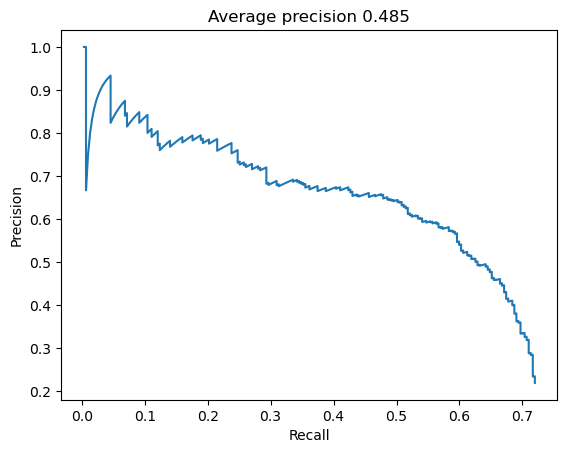

In [22]:
eval_detections(detections,scores,file_names)

In [72]:
def show_detections_with_ground_truth(detections, scores, file_names, params: Parameters):
    """
    Afiseaza si salveaza imaginile adnotate. Deseneaza bounding box-urile prezice si cele corecte.
    detections: numpy array de dimensiune NX4, unde N este numarul de detectii pentru toate imaginile.
    detections[i, :] = [x_min, y_min, x_max, y_max]
    scores: numpy array de dimensiune N, scorurile pentru toate detectiile pentru toate imaginile.
    file_names: numpy array de dimensiune N, pentru fiecare detectie trebuie sa salvam numele imaginii.
    (doar numele, nu toata calea).
    """

    ground_truth_bboxes = np.loadtxt(params.path_annotations, dtype='str')
    test_images_path = os.path.join(params.dir_validation_examples, '*.jpg')
    test_files = glob.glob(test_images_path)

    for test_file in test_files:
        image = cv.imread(test_file)
        short_file_name = ntpath.basename(test_file)
        indices_detections_current_image = np.where(file_names == short_file_name)
        current_detections = detections[indices_detections_current_image]
        current_scores = scores[indices_detections_current_image]

        for idx, detection in enumerate(current_detections):
            cv.rectangle(image, (detection[0], detection[1]), (detection[2], detection[3]), (0, 0, 255), thickness=1)
            cv.putText(image, 'score:' + str(current_scores[idx])[:4], (detection[0], detection[1]),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        annotations = ground_truth_bboxes[ground_truth_bboxes[:, 0] == short_file_name]

        # show ground truth bboxes
        for detection in annotations:
            cv.rectangle(image, (int(detection[1]), int(detection[2])), (int(detection[3]), int(detection[4])), (0, 255, 0), thickness=1)

        cv.imwrite(os.path.join(params.dir_save_files, "detections_" + short_file_name), image)
        print('Apasa orice tasta pentru a continua...')
        cv.imshow('image', np.uint8(image))
        cv.waitKey(0)

In [141]:
show_detections_with_ground_truth(detections,scores,file_names,parameters)

Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru a continua...
Apasa orice tasta pentru 

KeyboardInterrupt: 

In [ ]:
def run_everything():
    save_load_descriptors('fisiereSalvate',override=False)
    train_data = np.concatenate((np.squeeze(all_positive_descriptor), np.squeeze(all_negative_descriptor)), axis=0)
    train_labels = np.concatenate((np.ones(all_positive_descriptor.shape[0]), np.zeros(all_negative_descriptor.shape[0])),
                                  axis=0)
    best_model = train_classifier(train_data, train_labels, 'fisiereSalvate')
    detections, scores, file_names = run('validare/validare', best_model)
    eval_detections(detections, scores, file_names)
    show_detections_with_ground_truth(detections, scores, file_names, parameters)

In [ ]:
run_everything()

Antrenam un clasificator pentru c=0.000010
0.8140169902912622
Antrenam un clasificator pentru c=0.000100
0.9181836569579288
Antrenam un clasificator pentru c=0.001000
0.9778519417475728
Antrenam un clasificator pentru c=0.010000
1.0
Antrenam un clasificator pentru c=0.100000
1.0
Antrenam un clasificator pentru c=1.000000
1.0
Performanta clasificatorului optim pt c = 0.010000


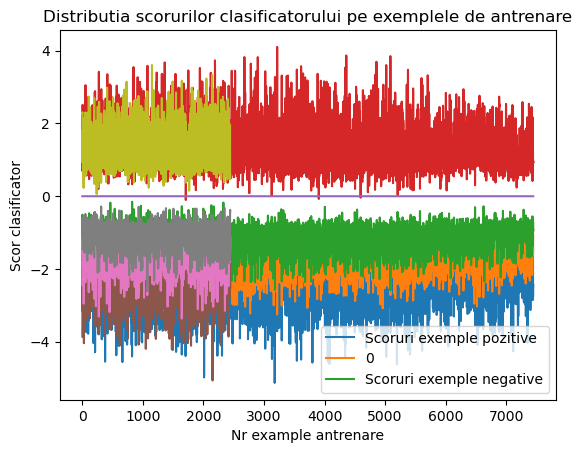

In [73]:
dad_labels = np.zeros(len(dad_positive_descriptors))  # Label 0 for 'dad'
deedee_labels = np.ones(len(deedee_positive_descriptors))  # Label 1 for 'deedee'
dexter_labels = np.full(len(dexter_positive_descriptors), 2)  # Label 2 for 'dexter'
mom_labels = np.full(len(mom_positive_descriptors), 3)  # Label 3 for 'mom'
# unknown_labels = np.full(len(unknown_positive_descriptors), 4)  # Label 4 for 'unknown'

X = np.concatenate((dad_positive_descriptors,
                    deedee_positive_descriptors,
                    dexter_positive_descriptors,
                    mom_positive_descriptors,
                    # unknown_positive_descriptors
                    ), axis=0)

y = np.concatenate((dad_labels,
                    deedee_labels,
                    dexter_labels,
                    mom_labels,
                    # unknown_labels
                    ), axis=0)
    
best_model_characters = train_classifier(X, y, 'fisiereSalvateCerinta2')


In [74]:
def extract_descriptor_from_detection(detection, image):
    """
    Extracts a HOG descriptor from a specific detection (bounding box) in the image.

    :param detection: List or array [x_min, y_min, x_max, y_max] specifying the bounding box of the detection.
    :param image: The image from which the descriptor will be extracted.
    :param cell_size: The size of a cell (default is 8).
    :param block_size: The number of cells per block (default is (2, 2)).
    :param pixels_per_cell: The number of pixels per cell (default is (8, 8)).

    :return: The HOG descriptor for the cropped detection area.
    """
    # Unpack the bounding box coordinates
    x_min, y_min, x_max, y_max = detection
    
    # Crop the detection area from the image
    cropped_img = image[y_min:y_max, x_min:x_max]

    # Resize the cropped image if needed to match the window size (parameters.dim_window)
    resized_img = cv.resize(cropped_img, (parameters.dim_window, parameters.dim_window), interpolation=cv.INTER_LINEAR)

    # Compute the HOG descriptor for the cropped and resized image
    hog_descriptor = hog(resized_img, 
                         pixels_per_cell=parameters.dim_hog_cell, 
                         cells_per_block=(2,2), 
                         visualize=False, 
                         multichannel=False)
    
    return hog_descriptor

In [75]:
def run_character(test_path,model,distinguish_model,label):
    
        """
        Aceasta functie returneaza toate detectiile ( = ferestre) pentru toate imaginile din self.params.dir_test_examples
        Directorul cu numele self.params.dir_test_examples contine imagini ce
        pot sau nu contine fete.
        Functia 'non_maximal_suppression' suprimeaza detectii care se suprapun (protocolul de evaluare considera o detectie duplicata ca fiind falsa)
        Suprimarea non-maximelor se realizeaza pe pentru fiecare imagine.
        :return:
        detections: numpy array de dimensiune NX4, unde N este numarul de detectii pentru toate imaginile.
        detections[i, :] = [x_min, y_min, x_max, y_max]
        scores: numpy array de dimensiune N, scorurile pentru toate detectiile pentru toate imaginile.
        file_names: numpy array de dimensiune N, pentru fiecare detectie trebuie sa salvam numele imaginii.
        (doar numele, nu toata calea).
        """
        
        test_images_path = os.path.join(test_path, '*.jpg')
        test_files = glob.glob(test_images_path)
        detections = None  # array cu toate detectiile pe care le obtinem
        scores = np.array([])  # array cu toate scorurile pe care le obtinem
        file_names = np.array([])  # array cu fisiele, in aceasta lista fisierele vor aparea de mai multe ori, pentru fiecare
        # detectie din imagine, numele imaginii va aparea in aceasta lista
        w = model.coef_.T
        bias = model.intercept_[0]
        num_test_images = len(test_files)
        #scales=[0.5,0.75,1,1.25,1.5,1.75,2]
        scales = [1]
        for i in range(num_test_images):
            start_time = timeit.default_timer()
            print('Procesam imaginea de testare %d/%d..' % (i, num_test_images))
            img = cv.imread(test_files[i], cv.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image {test_files[i]}. Skipping.")
                continue
            # TODO: completati codul functiei in continuare
            image_scores = []
            image_detections = []
            short_name = ntpath.basename(test_files[i])
            for scale in scales:
                scaled_img = cv.resize(img, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
                hog_descriptors = hog(scaled_img, pixels_per_cell=(parameters.dim_hog_cell,parameters.dim_hog_cell),
                                    cells_per_block=(2, 2), feature_vector=False)
                # Calculate HOG descriptor grid dimensions
                num_cols = scaled_img.shape[1] // parameters.dim_hog_cell - 1
                num_rows = scaled_img.shape[0] // parameters.dim_hog_cell - 1
                num_cell_in_template = parameters.dim_window // parameters.dim_hog_cell - 1

                for y in range(0, num_rows - num_cell_in_template):
                    for x in range(0, num_cols - num_cell_in_template):
                        descr = hog_descriptors[y:y + num_cell_in_template, x:x + num_cell_in_template].flatten()
                        prediction = distinguish_model.predict([descr])
                        class_label = prediction[0]
                        if class_label == label:
                            score = np.dot(descr, w)[0] + bias
                            if score > parameters.threshold:
                                x_min = int(x * parameters.dim_hog_cell / scale)
                                y_min = int(y * parameters.dim_hog_cell / scale)
                                x_max = int(x_min + parameters.dim_window / scale)
                                y_max = int(y_min + parameters.dim_window / scale)
                                image_detections.append([x_min, y_min, x_max, y_max])
                                image_scores.append(score)
            if len(image_scores) > 0:
                image_detections, image_scores = non_maximal_suppression(np.array(image_detections),
                                                                              np.array(image_scores), img.shape)
                if detections is None:
                    detections = image_detections
                else:
                    detections = np.concatenate((detections, image_detections))
                scores = np.append(scores, image_scores)
                image_names = [short_name for ww in range(len(image_scores))]
                file_names = np.append(file_names, image_names)
            end_time = timeit.default_timer()
            print('Timpul de procesarea al imaginii de testare %d/%d este %f sec.'
                                  % (i, num_test_images, end_time - start_time))


        return detections,scores, file_names

In [76]:
dad_pred,dad_scores,dad_file_names = run_character('validare/validare',best_model_characters,best_model_characters,0)
deedee_pred,deedee_scores,deedee_file_names = run_character('validare/validare',best_model_characters,best_model_characters,1)
dexter_pred,dexter_scores,dexter_file_names = run_character('validare/validare',best_model_characters,best_model_characters,2)
mom_pred,mom_scores,mom_file_names = run_character('validare/validare',best_model_characters,best_model_characters,3)

Procesam imaginea de testare 0/200..
[] []
Timpul de procesarea al imaginii de testare 0/200 este 0.666785 sec.
Procesam imaginea de testare 1/200..
[] []
Timpul de procesarea al imaginii de testare 1/200 este 0.916275 sec.
Procesam imaginea de testare 2/200..
[] []
Timpul de procesarea al imaginii de testare 2/200 este 0.714124 sec.
Procesam imaginea de testare 3/200..
[] []
Timpul de procesarea al imaginii de testare 3/200 este 0.691415 sec.
Procesam imaginea de testare 4/200..
[] []
Timpul de procesarea al imaginii de testare 4/200 este 0.714068 sec.
Procesam imaginea de testare 5/200..
[] []
Timpul de procesarea al imaginii de testare 5/200 este 0.701013 sec.
Procesam imaginea de testare 6/200..
[] []
Timpul de procesarea al imaginii de testare 6/200 este 0.678596 sec.
Procesam imaginea de testare 7/200..
[] []
Timpul de procesarea al imaginii de testare 7/200 este 0.786930 sec.
Procesam imaginea de testare 8/200..
[] []
Timpul de procesarea al imaginii de testare 8/200 este 0.7355

In [77]:
def eval_detections_character(detections, scores, file_names,ground_truth_path,character):
    ground_truth_file = np.loadtxt(ground_truth_path, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], np.int64)

    num_gt_detections = len(ground_truth_detections)  # numar total de adevarat pozitive
    gt_exists_detection = np.zeros(num_gt_detections)
    # sorteazam detectiile dupa scorul lor
    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    scores = scores[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        # clasifica o detectie ca fiind adevarat pozitiva / fals pozitiva
        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(character + ' faces: average precision %.3f' % average_precision)
    plt.savefig('precizie_medie_' + character + '.png')
    plt.show()

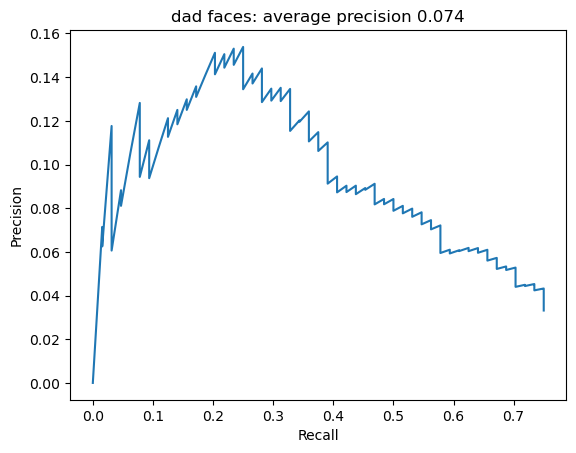

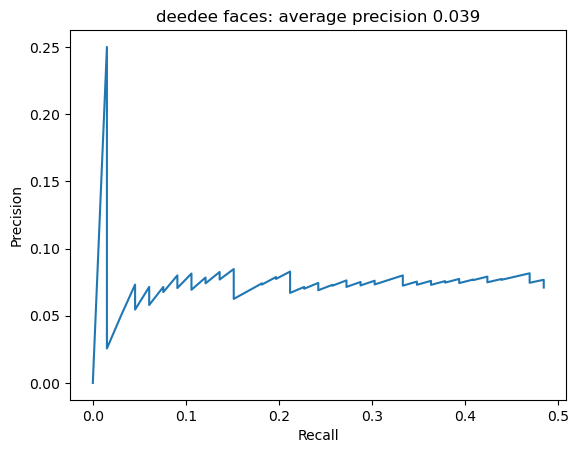

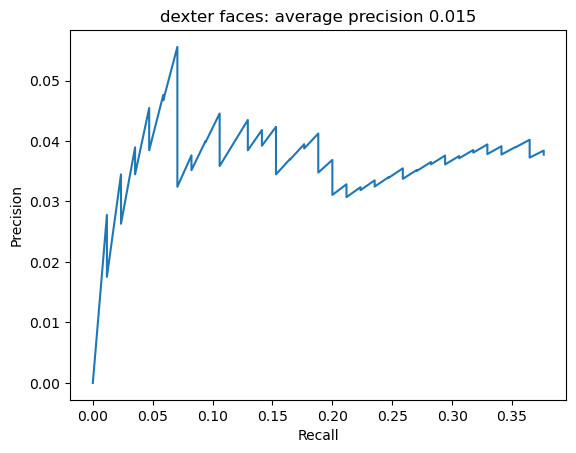

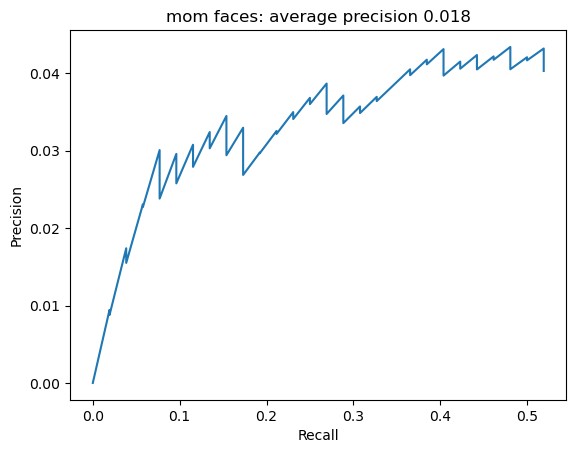

In [78]:
ground_truth_path = 'validare/task2_dad_gt_validare.txt'
eval_detections_character(dad_pred,dad_scores,dad_file_names,ground_truth_path,'dad')
ground_truth_path = 'validare/task2_deedee_gt_validare.txt'
eval_detections_character(deedee_pred,deedee_scores,deedee_file_names,ground_truth_path,'deedee')
ground_truth_path = 'validare/task2_dexter_gt_validare.txt'
eval_detections_character(dexter_pred,dexter_scores,dexter_file_names,ground_truth_path,'dexter')
ground_truth_path = 'validare/task2_mom_gt_validare.txt'
eval_detections_character(mom_pred,mom_scores,mom_file_names,ground_truth_path,'mom')
